First install all the requirements from the root directory (`pip install -r requirements.txt --user`), then switch to the demo directory (same as this notebook) and run the install script (`sh script.sh`) from the demo directory to get the models (optimized and non-optimized) and to install the additional libraries for the demo.

In [ ]:
!sh script.sh

Next, import all the methods from the `model.py` file. If you do this but get empty black images when you try generating things later (or if blockparse failed to install for you) then you need to change line 25 (`optimized = True`) in `model.py` to `optimized = False`, reload the kernel, and re-import model.

In [1]:
from model import *

Loaded model
Warm started tf model


Now let's open and display the image. If the image is empty or does not load properly, it may not have found a face. To fix this, crop the image so that the face is most of it (>50%). Ideally the image is bigger than 256px on each side. Note you could also crop and align the face manually and then just load the image without aligning it using:

    img = Image.open('faces/%s'%path1)
    img = img.convert('RGB')  # if image is RGBA or Grayscale etc
    img = img.resize((256,256), Image.BICUBIC)
    img = np.array(img)
    

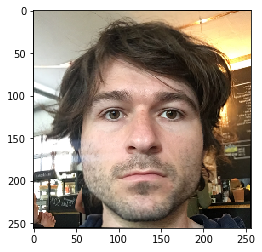

In [58]:
from align_face import *

img = align('gene.png')
pyplot.imshow(img)

Now let's encode the image into its latent vector. It has to be reshaped as a tensor and then use the `encode` function.

In [59]:
img = np.reshape(np.array(img), [1, 256, 256, 3])
z = encode(img)
print("shape of z: ", z.shape)  # i.e. 256x256x3
print("z=", z)

shape of z:  (1, 196608)
z= [[-2.8401651 -2.3757095 -1.172135  ...  2.1781569 -1.8776252  1.6606328]]


Now let's decode z into an image, and then display that image. Notice that it looks exactly the same as the original image. Also note that it returns a tensor of size [1, 256, 256, 3] so we have to pull out the first one at index 0.

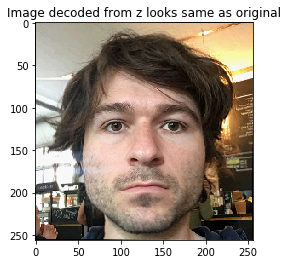

In [60]:
x_new = decode(z)

pyplot.figure()
pyplot.title('Image decoded from z looks same as original')
pyplot.imshow(x_new[0])

Let's make some changes to z. We can add attribute vectors.

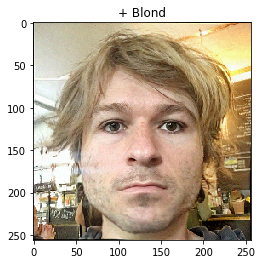

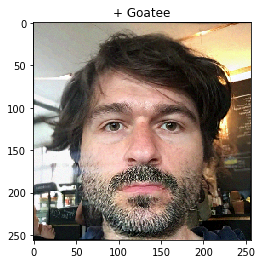

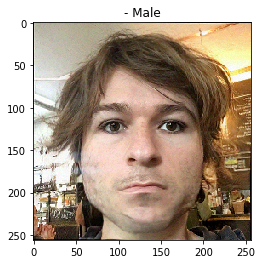

In [72]:
tags = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
tags = tags.split()

# take original z, and 0.9 * the manipulation vector corresponding to blond hair
z_blond = np.copy(z)
z_blond[0] += 0.7 * z_manipulate[tags.index('Blond_Hair')]
x_blond = decode(z_blond)

pyplot.figure()
pyplot.title('+ Blond')
pyplot.imshow(x_blond[0])

# same thing, but goatee
z_goatee = np.copy(z)
z_goatee[0] += 0.7 * z_manipulate[tags.index('Goatee')]
x_goatee = decode(z_goatee)

pyplot.figure()
pyplot.title('+ Goatee')
pyplot.imshow(x_goatee[0])

# same thing but do opposite of male (subtract male)
z_male = np.copy(z)
z_male[0] -= 0.7 * z_manipulate[tags.index('Male')]
x_male = decode(z_male)

pyplot.figure()
pyplot.title('- Male')
pyplot.imshow(x_male[0])


Now let's load two images and try to interpolate between them. First load two faces.

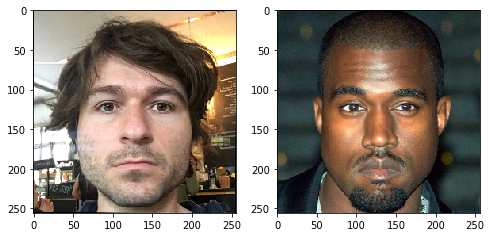

In [107]:
img1 = align('gene.png')
img2 = align('kanye.jpg')
pyplot.figure(figsize=(8,4))
pyplot.subplot(1, 2, 1)
pyplot.imshow(img1)
pyplot.subplot(1, 2, 2)
pyplot.imshow(img2)

Now encode both of them and interpolate frames between their two z-vectors.

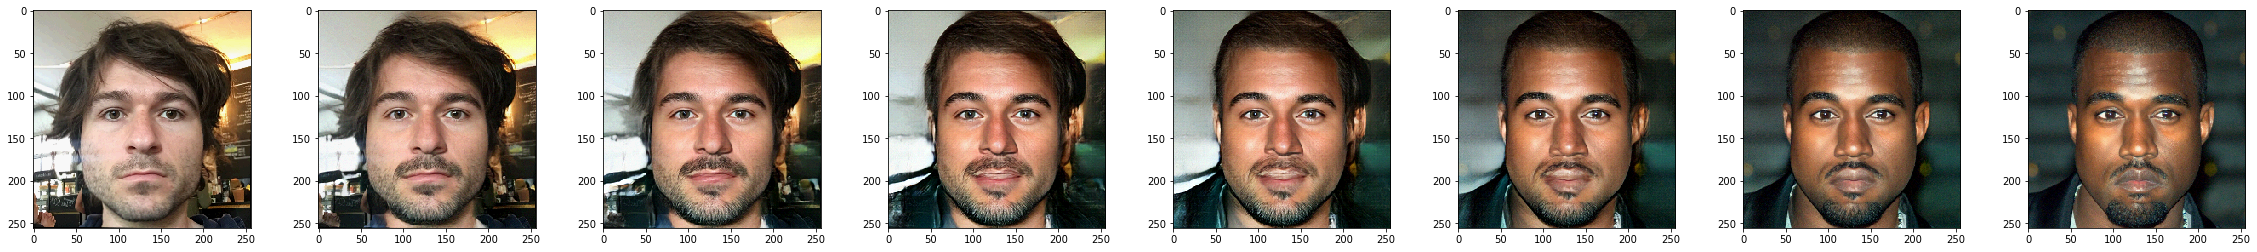

In [108]:
z1 = encode(img1)
z2 = encode(img2)

pyplot.figure(figsize=(40,4))
for i in range(8):
    ratio = float(i) / 7
    z_tween = np.copy(z1)
    z_tween[0] = (1.0-ratio) * z1 + ratio * z2
    img_tween = decode(z_tween)
    pyplot.subplot(1, 8, i+1)
    pyplot.imshow(img_tween[0])

Let's make new faces. To do that, we sample a z-vector from a random normal distribution using `numpy.random.randn`. We multiply the magnitude by a scalar we call the "temperature". A very low temperature gives you very believable but average-looking and repetive faces. A very high temperature gives you more diversity but less realism. Let's try at a few different values.

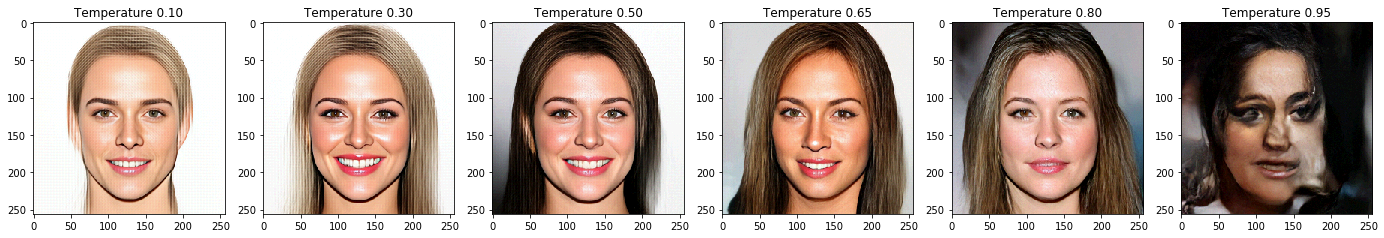

In [99]:
temperatures = [0.1, 0.3, 0.5, 0.65, 0.8, 0.95]
pyplot.figure(figsize=(24, 4))
for t, temperature in enumerate(temperatures):
    z_new = np.array([temperature * np.random.randn(256*256*3)])
    x_new = decode(z_new)
    pyplot.subplot(1, len(temperatures), t+1)
    pyplot.title('Temperature %0.2f' % temperature)
    pyplot.imshow(x_new[0])
